In [1]:
from pathlib import Path
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

__wd__ = Path("__file__").resolve().parent
datasets_path = __wd__ / "datasets"

ecoisole = pd.read_csv(datasets_path / 'ecoisole.csv', sep=";", encoding='cp1252')
people = pd.read_csv(datasets_path / 'consumers.csv', sep=";", encoding='cp1252')

parte1 = pd.read_csv(datasets_path / 'deposits1.csv', sep=",")
parte2 = pd.read_csv(datasets_path / 'deposits2.csv', sep=",")
parte3 = pd.read_csv(datasets_path / 'deposits3.csv', sep=",")
parte4 = pd.read_csv(datasets_path / 'deposits4.csv', sep=",")
# Unisci i quattro DataFrame in uno unico
data = pd.concat([parte1, parte2, parte3, parte4], ignore_index=True)

In [2]:
#Preprocessing Ecoisole
ecoisole = ecoisole.loc[:, ['id','lat','lng']]
ecoisole = ecoisole.drop(ecoisole[ecoisole['id'] > 15].index)
ecoisole.head()

,id,lat,lng
0,1,42.766255,10.393068
1,2,42.763764,10.399147
2,3,42.767637,10.400593
3,4,42.760175,10.370516
4,5,42.769767,10.398599


In [6]:
#Preprocessing Clients
people['name'] = people['name'].astype(str)

# Definiamo una funzione che unisce il contenuto delle colonne 'colonna1' e 'colonna2' solo se la colonna 'colonna2' non è NaN
def unisci(colonna1, colonna2):
    if pd.notna(colonna2):
        return colonna1 + ' ' + colonna2
    else:
        return colonna1

# Applichiamo la funzione 'unisci' utilizzando il metodo .apply() di Pandas
people['name'] = people.apply(lambda row: unisci(row['name'], row['surname']), axis=1)
people = people.drop('surname', axis=1)
people = people.rename(columns={'id': 'consumer_id'})


people.head()

,consumer_id,id_location,code,consumer_category_id,name,neighborhood,address,number_of_residence
0,9452,5,4744,7,Pamela Bianchi,NaN,Via Romita,9
1,8679,5,3968,7,DORIS Rossi,NaN,LOCALITA' BOTRO,NaN
2,9462,5,4753,7,Giorgio Neri,NaN,Località Terranera,NaN
3,5327,5,614,7,Gaspare Grigi,NaN,LOCALITA' CASINA,NaN
4,5208,5,495,7,Valentina Bianchi,NaN,VIALE EUROPA,12


In [3]:

data['Data'] = pd.to_datetime(data['created_at'])
data = data.loc[:, ['id','consumer_id','ecoisola_id','Data']]
data = data[data['Data'].dt.year == 2022]
data = data[~data['Data'].dt.month.isin([6, 7, 8])]


data.head()

,id,consumer_id,ecoisola_id,Data
1,87122,7032,7,2022-01-04 17:44:00
12,87133,4721,7,2022-01-04 17:42:47
14,87135,4721,7,2022-01-04 17:43:50
18,87139,6107,7,2022-01-04 17:42:37
21,87142,6107,7,2022-01-04 17:43:35


In [8]:
merged_df = pd.merge(data, people, on='consumer_id')


In [9]:
def draw(G,pos,measures,measures_name):
    nodes=nx.draw_networkx_nodes(G,pos,node_size=250, cmap=plt.cm.plasma, node_color=list(measures.values()), nodelist= measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01,linscale=1))
    edges=nx.draw_networkx_edges(G,pos)

    plt.title(measures_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

In [10]:
join_df = merged_df.groupby(['ecoisola_id', 'consumer_id','name']).size().reset_index(name='weight')

join_df = join_df.drop(join_df[join_df['ecoisola_id'] > 15].index)
join_df = join_df.drop(join_df[join_df['weight'] < 30].index)

mediana = join_df['weight'].median()
#print(mediana)

grouped = join_df.groupby('ecoisola_id')['consumer_id'].apply(list).reset_index(name='consumer_ids')

# creo un nuovo DataFrame con i campi richiesti
new_df = pd.DataFrame(columns=['ecoisola_id', 'consumer_id_1', 'consumer_id_2', 'weight_1', 'weight_2'])

# ciclo sui gruppi di consumer_id
for i in range(len(grouped)):
    # creo una lista di tuple di tutte le possibili coppie di consumer_id all'interno del gruppo
    pairs = [(grouped['consumer_ids'][i][j], grouped['consumer_ids'][i][k], join_df[(join_df['consumer_id'] == grouped['consumer_ids'][i][j]) & (join_df['ecoisola_id'] == grouped['ecoisola_id'][i])]['weight'].iloc[0], join_df[(join_df['consumer_id'] == grouped['consumer_ids'][i][k]) & (join_df['ecoisola_id'] == grouped['ecoisola_id'][i])]['weight'].iloc[0]) for j in range(len(grouped['consumer_ids'][i])) for k in range(j+1, len(grouped['consumer_ids'][i]))]
    # aggiungo le coppie al nuovo DataFrame
    for pair in pairs:
        new_df = new_df.append({'ecoisola_id': grouped['ecoisola_id'][i], 'consumer_id_1': pair[0], 'consumer_id_2': pair[1], 'weight_1': pair[2], 'weight_2': pair[3]}, ignore_index=True)

# visualizzo il nuovo DataFrame
print(new_df)
#FINE PREPROCESSING

      ecoisola_id consumer_id_1 consumer_id_2 weight_1 weight_2
0               1          5082          5338       37       85
1               1          5082          5484       37       76
2               1          5082          5536       37      127
3               1          5082          5687       37       62
4               1          5082          5969       37       42
...           ...           ...           ...      ...      ...
31451          15          8987          9198       89       50
31452          15          8987          9240       89       40
31453          15          9148          9198       34       50
31454          15          9148          9240       34       40
31455          15          9198          9240       50       40

[31456 rows x 5 columns]


NODES:  793
EDGES:  31278
DENSITY:  0.1
CLUSTERING:  0.9560571164910647
IS_CONNECTED:  True


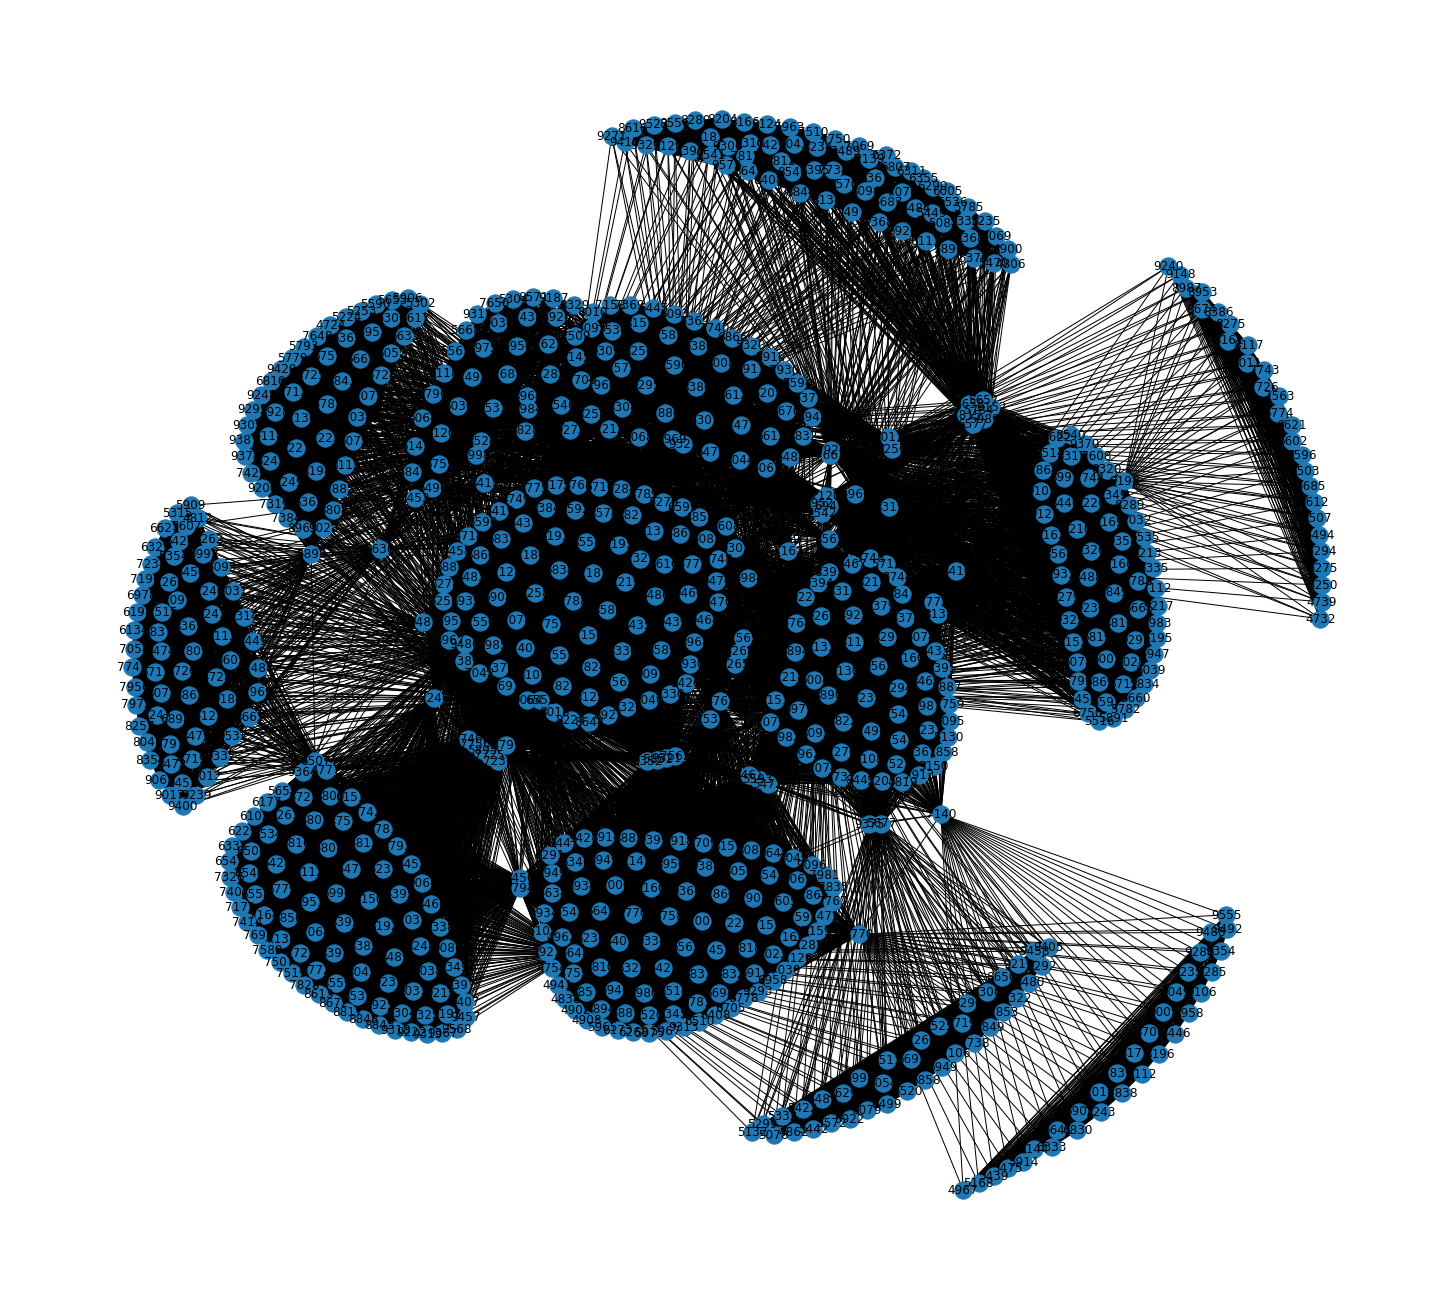

In [18]:

G = nx.Graph()
G.add_edges_from(zip(new_df['consumer_id_1'], new_df['consumer_id_2']))

# Visualizziamo le informazioni sul grafo creato
print("NODES: ", len(G.nodes))
print("EDGES: ", len(G.edges))
print("DENSITY: ", round(nx.density(G),3))
print("CLUSTERING: ", nx.average_clustering(G))
#print("RAGGIO: ",nx.radius(G))
#print("DIAMETRO: ",nx.diameter(G))
print("IS_CONNECTED: ", nx.is_connected(G))


plt.figure(figsize=(20,18))
pos=nx.kamada_kawai_layout(G)


nx.draw(G,pos, with_labels=True )


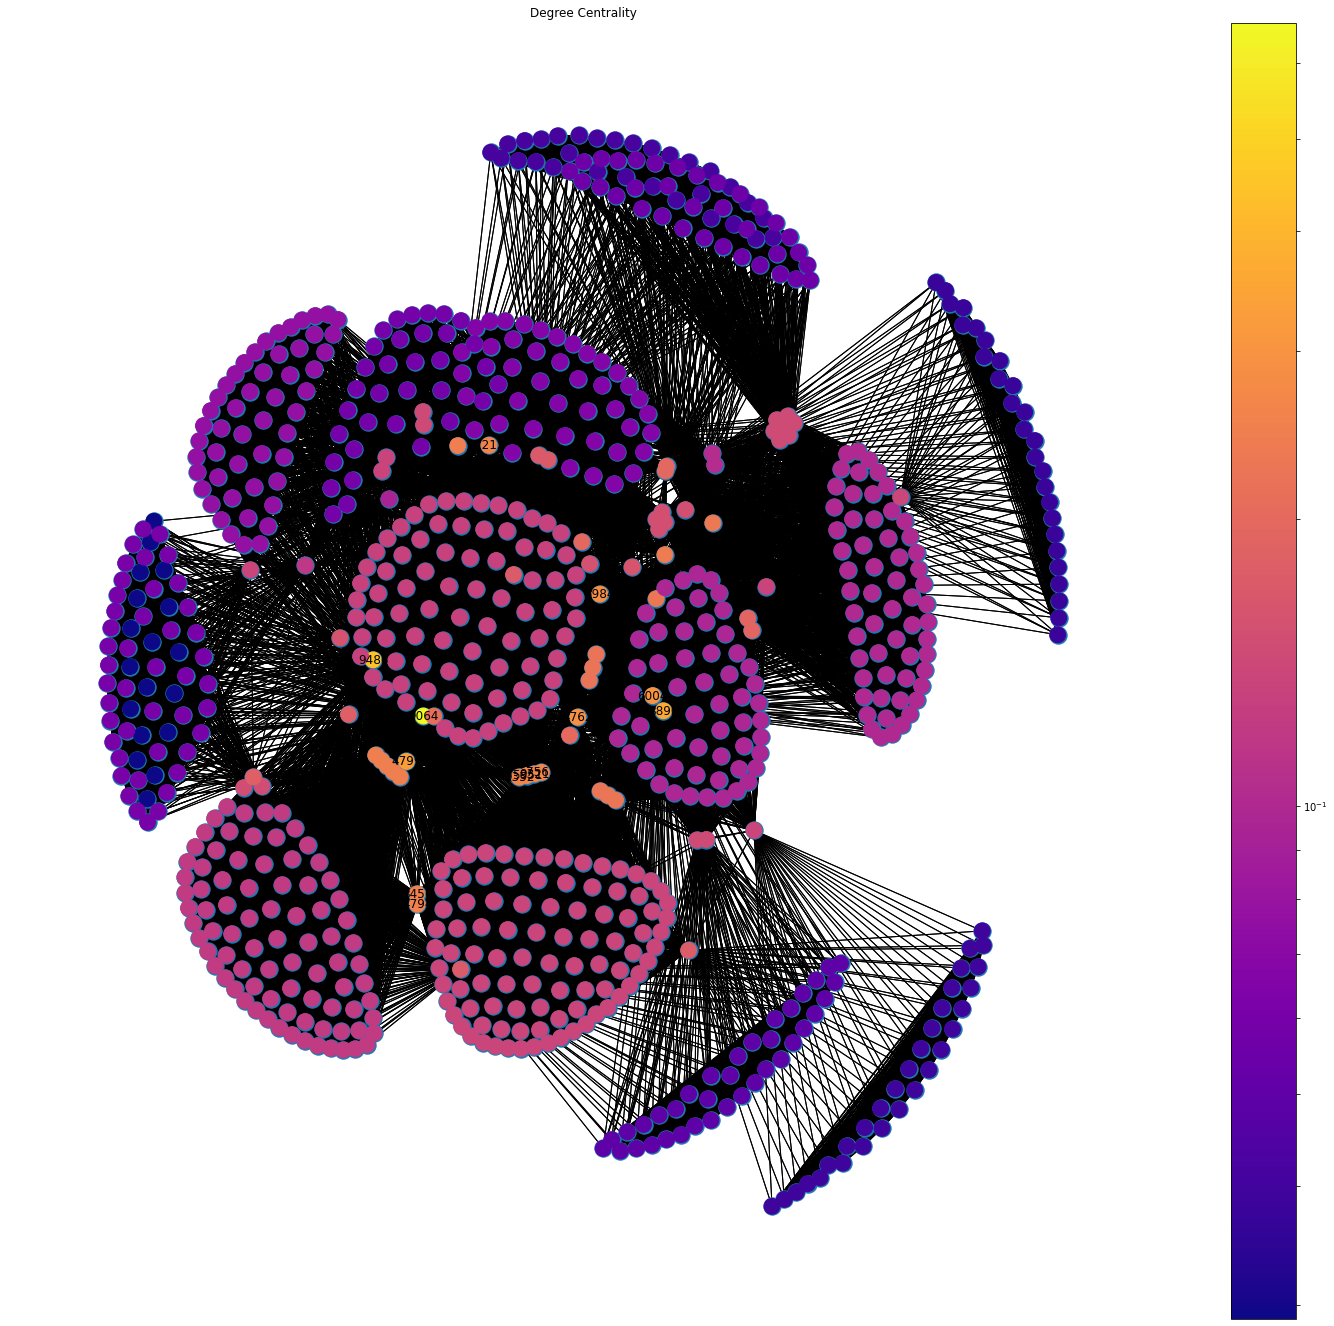

In [19]:
degree=nx.degree_centrality(G)
sorted_centrality = sorted(degree.items(), key=lambda x: x[1], reverse=True)

# Prendiamo i primi 10 elementi della lista ordinata
top_10 = sorted_centrality[:10]

labels={}
for key, value in degree.items():
    if value > 0.25:
        labels[key] = key
pos=nx.kamada_kawai_layout(G)
plt.figure(figsize=(20,18))
nx.draw(G,pos, with_labels=False)
nx.draw_networkx_labels(G,pos,labels)
draw(G, pos, degree, 'Degree Centrality')

In [11]:

# Creazione del DataFrame
df_top10 = pd.DataFrame(top_10, columns=['consumer_id', 'Degree Centrality'])
top_10



NameError: name 'top_10' is not defined

In [12]:
from sklearn.preprocessing import MinMaxScaler

##In data ho tutte le possibili ecoisole
nodo_analisi=8890

filtro = data.loc[data['consumer_id'] == nodo_analisi]
numero_occorrenze = filtro['ecoisola_id'].value_counts().reset_index()
numero_occorrenze = numero_occorrenze.rename(columns={'ecoisola_id': 'conteggio'})
numero_occorrenze = numero_occorrenze.rename(columns={'index': 'id'})
numero_occorrenze = numero_occorrenze[numero_occorrenze['id'] <= 15]

scaler = MinMaxScaler(feature_range=(0, 1))
numero_occorrenze['conteggio_scalato'] = scaler.fit_transform(numero_occorrenze[['conteggio']])


##In all ho il codice postale e la via
filtro2 = people.loc[people['consumer_id'] == nodo_analisi]
address=filtro2['address'].iloc[0]

print(numero_occorrenze)
print(address)

   id  conteggio  conteggio_scalato
1  11        209           1.000000
2   7         60           0.283654
3  10         51           0.240385
4  13         30           0.139423
6   3          1           0.000000
7  12          1           0.000000
PIAZZA DE SANTIS


In [13]:
from geopy.geocoders import Nominatim

# istanzia il geocodificatore
geolocator = Nominatim(user_agent="my_app")

# indirizzo da cercare
street = address
postal_code = "57036"
address = f"{street}, LI , {postal_code} , Italy"
#address =  "PIANETTO 21, Porto Azzurro , Italy"

# esegui la geocodifica inversa
location = geolocator.geocode(address)

# se la geocodifica ha avuto successo, stampa le coordinate
if location:
    latitude, longitude = location.latitude, location.longitude
    print(f"Le coordinate di {address} sono: ({latitude}, {longitude})")
else:
    print(f"Impossibile trovare le coordinate di {address}")
    address=""
    latitude=42.768476899999996
    longitude=10.39578431056701

Le coordinate di PIAZZA DE SANTIS, LI , 57036 , Italy sono: (42.76781905, 10.395274143782133)


In [14]:
ecoisole_merged = pd.DataFrame()

ecoisole_merged = pd.concat([ecoisole_merged, pd.merge(numero_occorrenze, ecoisole, on='id', how='inner')], ignore_index=True)

ecoisole_merged



,id,conteggio,conteggio_scalato,lat,lng
0,11,209,1.000000,42.767963,10.395710
1,7,60,0.283654,42.768874,10.398032
2,10,51,0.240385,42.765367,10.395023
3,13,30,0.139423,42.770275,10.397580
4,3,1,0.000000,42.767637,10.400593
5,12,1,0.000000,42.768436,10.398207


In [ ]:
import folium
from geopy import distance
import branca.colormap as cm

# coordinata del punto A (latitudine, longitudine)
point_a = (latitude, longitude)

# creazione della mappa centrata sul punto A
map_center = point_a

m = folium.Map(location=map_center, zoom_start=16, zoom_control=False)
colormap = cm.LinearColormap(['blue', 'red'], vmin=0, vmax=1).add_to(m)
colormap.caption = 'Legenda'

for index, row in ecoisole_merged.iterrows():
    name= str(row['id'])
    lat = row['lat']
    lon = row['lng']
    weight= row['conteggio_scalato']
    peso= int(row['conteggio'])
    d=int(distance.distance(point_a, (lat, lon)).m)
    popup = f"Ecoisola_{name}:".replace('.0', '')+f" Num.Conferimenti:{peso} Distanza:{d}metri"
    
    colore = colormap(weight)
    
    folium.PolyLine(locations=[point_a, (lat,lon)],color=colore, opacity=0.5, tooltip="Distanza: {:.2f} metri".format(d)).add_to(m)
    icon = folium.Icon(icon='cloud', icon_color=colore)
    folium.CircleMarker(location=[lat, lon], popup=popup ,radius=20,fill_color=colore, fill_opacity=0.9).add_to(m)
    
    if name==9:
        map_center = (lat,lon)


folium.Marker(location=point_a, tooltip="Il mio punto").add_to(m)


# imposta l'estensione della mappa in modo che sia centrata sul punto e più zoommata
m.fit_bounds(map_center)

# visualizzazione della mappa
m

